# Appendix 04 - Exploring Clustering Methods: *Deterministic and Stochastic approaches*

In [462]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from models.deterministic_radially_constrained_cluster import *  # Adjust import as per your package structure
from models.radially_constrained_cluster import *
from models.X_RCC import XRCC
from visualization.custom_plots import standard_format, day_of_year_to_date
import itertools
import requests

In [463]:
# -- PARAMETERS 

# Common parameters
n_seas = 4
min_len= 30
metric = 'euclidean'

# Deterministic model parameters
n_days = list(np.arange(0,365,5))

# Stochastic model parameters
iters = 1000
learning_rate   = 1

starting_bp     = [61, 153,245,336]

lat = 28
lon = 80

In [464]:
latitude = '45.41'
longitude = '11.88'

start = '2040-01-01'
end = '2050-12-31'
variable = 'temperature_2m'
model = 'era5'

#link = f'https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start}&end_date={end}&hourly={variable}&models={model}'
link = f'https://climate-api.open-meteo.com/v1/climate?latitude={latitude}&longitude={longitude}&start_date={start}&end_date={end}&models=EC_Earth3P_HR&daily=temperature_2m_mean,temperature_2m_max,temperature_2m_min,wind_speed_10m_mean,wind_speed_10m_max,cloud_cover_mean,shortwave_radiation_sum,relative_humidity_2m_mean,relative_humidity_2m_max,relative_humidity_2m_min,dew_point_2m_mean,dew_point_2m_min,dew_point_2m_max,precipitation_sum,rain_sum,snowfall_sum,pressure_msl_mean,soil_moisture_0_to_10cm_mean,et0_fao_evapotranspiration_sum'
f = requests.get(link, verify=False)
data = f.json()

dat = pd.DataFrame(data['daily'])

# convert dat.time in datetime
dat['time'] = pd.to_datetime(dat['time'])
dat = dat.set_index('time')

dat = dat.resample('D').mean()

dat = dat.rolling(window=15).mean()

/home/jgrassi/miniconda3/lib/python3.11/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'climate-api.open-meteo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [465]:
data

{'latitude': 45.40001,
 'longitude': 11.900009,
 'generationtime_ms': 26.20100975036621,
 'utc_offset_seconds': 0,
 'timezone': 'GMT',
 'timezone_abbreviation': 'GMT',
 'elevation': 19.0,
 'daily_units': {'time': 'iso8601',
  'temperature_2m_mean': '°C',
  'temperature_2m_max': '°C',
  'temperature_2m_min': '°C',
  'wind_speed_10m_mean': 'km/h',
  'wind_speed_10m_max': 'km/h',
  'cloud_cover_mean': '%',
  'shortwave_radiation_sum': 'MJ/m²',
  'relative_humidity_2m_mean': '%',
  'relative_humidity_2m_max': '%',
  'relative_humidity_2m_min': '%',
  'dew_point_2m_mean': '°C',
  'dew_point_2m_min': '°C',
  'dew_point_2m_max': '°C',
  'precipitation_sum': 'mm',
  'rain_sum': 'mm',
  'snowfall_sum': 'cm',
  'pressure_msl_mean': 'hPa',
  'soil_moisture_0_to_10cm_mean': 'm³/m³',
  'et0_fao_evapotranspiration_sum': 'mm'},
 'daily': {'time': ['2040-01-01',
   '2040-01-02',
   '2040-01-03',
   '2040-01-04',
   '2040-01-05',
   '2040-01-06',
   '2040-01-07',
   '2040-01-08',
   '2040-01-09',
   '2

In [466]:

#datasets = [dataset_tp, dataset_u100, dataset_v100]  # Add as many datasets as needed
#dat.precipitation.plot()

In [467]:
datasets_tab = dat
# Remove hours from datetime
datasets_tab.index = pd.to_datetime(datasets_tab.index.astype(str))

In [468]:
# Reshape the table to keep the day of the year as the index and for the columns the values of the different variables at each year.
# The final shape will be 365 * n_years x n_variables. Remove the empy values
datasets_tab_res = datasets_tab.pivot_table(index=datasets_tab.index.dayofyear, columns=datasets_tab.index.year)
datasets_tab_res.columns = [f'{var}_{year}' for var, year in datasets_tab_res.columns]
datasets_tab_res.columns

Index(['cloud_cover_mean_2040', 'cloud_cover_mean_2041',
       'cloud_cover_mean_2042', 'cloud_cover_mean_2043',
       'cloud_cover_mean_2044', 'cloud_cover_mean_2045',
       'cloud_cover_mean_2046', 'cloud_cover_mean_2047',
       'cloud_cover_mean_2048', 'cloud_cover_mean_2049',
       ...
       'wind_speed_10m_mean_2040', 'wind_speed_10m_mean_2041',
       'wind_speed_10m_mean_2042', 'wind_speed_10m_mean_2043',
       'wind_speed_10m_mean_2044', 'wind_speed_10m_mean_2045',
       'wind_speed_10m_mean_2046', 'wind_speed_10m_mean_2047',
       'wind_speed_10m_mean_2048', 'wind_speed_10m_mean_2049'],
      dtype='object', length=190)

In [469]:
dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.min(axis=0))/(datasets_tab_res.max(axis=0) - datasets_tab_res.min(axis=0))
#dataset_tab_res_norm = (datasets_tab_res - datasets_tab_res.mean(axis=0))/datasets_tab_res.std(axis=0)
dataset_tab_res_norm

,cloud_cover_mean_2040,cloud_cover_mean_2041,cloud_cover_mean_2042,cloud_cover_mean_2043,cloud_cover_mean_2044,cloud_cover_mean_2045,cloud_cover_mean_2046,cloud_cover_mean_2047,cloud_cover_mean_2048,cloud_cover_mean_2049,...,wind_speed_10m_mean_2040,wind_speed_10m_mean_2041,wind_speed_10m_mean_2042,wind_speed_10m_mean_2043,wind_speed_10m_mean_2044,wind_speed_10m_mean_2045,wind_speed_10m_mean_2046,wind_speed_10m_mean_2047,wind_speed_10m_mean_2048,wind_speed_10m_mean_2049
time,,,,,,,,,,,,,,,,,,,,,
1,NaN,0.620751,0.922619,0.829698,0.634648,0.000000,0.156982,0.699433,0.148992,0.754564,...,NaN,0.377150,0.496124,0.156767,0.182883,0.000000,0.203986,0.430332,0.034923,0.623529
2,NaN,0.536673,0.944444,0.832215,0.644940,0.001012,0.180399,0.704159,0.139351,0.678499,...,NaN,0.316953,0.427907,0.146056,0.139640,0.069964,0.191090,0.447393,0.037479,0.484706
3,NaN,0.511628,0.938492,0.886745,0.626072,0.087045,0.213356,0.674858,0.113935,0.628803,...,NaN,0.229730,0.392248,0.059396,0.150450,0.132690,0.242673,0.431280,0.015332,0.332941
4,NaN,0.597496,0.957341,0.890940,0.630360,0.184211,0.254120,0.649338,0.077125,0.621704,...,NaN,0.343980,0.370543,0.060370,0.119820,0.223160,0.283705,0.436019,0.005111,0.323529
5,NaN,0.620751,0.965278,0.869966,0.643225,0.281377,0.287944,0.584121,0.051709,0.555781,...,NaN,0.482801,0.308527,0.063291,0.107207,0.341375,0.334115,0.387678,0.000000,0.354118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,0.627053,0.997317,0.926587,0.609899,0.185249,0.328947,0.745013,0.161626,0.781770,0.997972,...,0.469190,0.427518,0.514729,0.165531,0.002703,0.256936,0.395076,0.046445,0.541738,0.985882
363,0.656039,0.994633,0.945437,0.594799,0.144082,0.309717,0.692108,0.119093,0.785276,1.000000,...,0.494718,0.414005,0.493023,0.160662,0.021622,0.260555,0.407972,0.040758,0.566440,1.000000
364,0.619324,0.987478,0.984127,0.583054,0.144082,0.215587,0.657415,0.089792,0.765995,0.936105,...,0.500000,0.393120,0.474419,0.129503,0.040541,0.247286,0.388042,0.000000,0.568995,0.967059


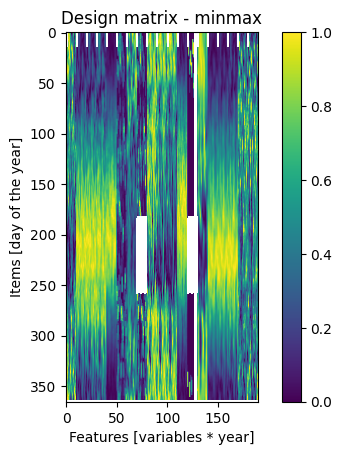

In [470]:
plt.figure()
plt.imshow(dataset_tab_res_norm.values)
plt.xlabel('Features [variables * year]')
plt.ylabel('Items [day of the year]')
plt.title('Design matrix - minmax')
plt.colorbar()

In [471]:
array_tot = dataset_tab_res_norm.values


/work/users/jgrassi/XSeasonsDetect/src/models/radially_constrained_cluster.py:304: RuntimeWarning: Mean of empty slice
  centroid = np.nanmean(data_cluster, axis=0)


Text(0, 0.5, 'WCSS')

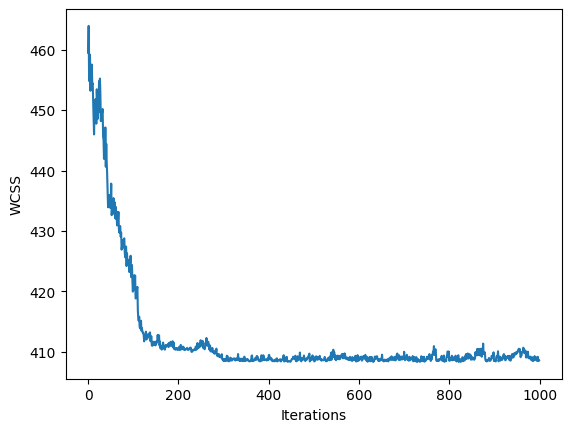

In [472]:
clustering_params = {
        'n_iter': iters,
        'n_seas': n_seas,
        'learning_rate': 1,
        'scheduling_factor':1,
        'min_len': 1,
        'mode': 'single',
        'starting_bp': starting_bp,
        'metric': metric,
    }

model = Radially_Constrained_Cluster(array_tot, **clustering_params)

model.fit()

plt.plot(model.error_history)
plt.xlabel('Iterations')
plt.ylabel('WCSS')

In [473]:
model.breakpoints

array([ 83, 153, 271, 326], dtype=int32)

In [474]:
[day_of_year_to_date(int(bp)) for bp in model.breakpoints]

['Mar 23rd', 'Jun 1st', 'Sep 27th', 'Nov 21st']

In [475]:
day_of_year_to_date(336)

'Dec 1st'

In [476]:
winter = model.get_index()[0].tolist()
spring = model.get_index()[1].tolist()
summer = model.get_index()[2].tolist()
fall = model.get_index()[3].tolist()

In [477]:
# select item with index in winter
winter_data = datasets_tab_res.iloc[winter, :]
spring_data = datasets_tab_res.iloc[spring, :]
summer_data = datasets_tab_res.iloc[summer, :]
fall_data = datasets_tab_res.iloc[fall, :]

# get columns with temperature in it
winter_data_mean = winter_data.loc[:, winter_data.columns.str.contains('temperature_2m_mean')]
winter_data_max = winter_data.loc[:, winter_data.columns.str.contains('temperature_2m_max')]
winter_data_min = winter_data.loc[:, winter_data.columns.str.contains('temperature_2m_min')]

spring_data_mean = spring_data.loc[:, spring_data.columns.str.contains('temperature_2m_mean')]
spring_data_max = spring_data.loc[:, spring_data.columns.str.contains('temperature_2m_max')]
spring_data_min = spring_data.loc[:, spring_data.columns.str.contains('temperature_2m_min')]
summer_data_mean = summer_data.loc[:, summer_data.columns.str.contains('temperature_2m_mean')]
summer_data_max = summer_data.loc[:, summer_data.columns.str.contains('temperature_2m_max')]
summer_data_min = summer_data.loc[:, summer_data.columns.str.contains('temperature_2m_min')]
fall_data_mean = fall_data.loc[:, fall_data.columns.str.contains('temperature_2m_mean')]
fall_data_max = fall_data.loc[:, fall_data.columns.str.contains('temperature_2m_max')]
fall_data_min = fall_data.loc[:, fall_data.columns.str.contains('temperature_2m_min')]


# print the mean, max and min, temperature for each season
print('Winter mean, max, min')
print(winter_data_mean.mean(axis=0).mean(), winter_data_max.mean(axis=0).mean(), winter_data_min.mean(axis=0).mean())
print('Spring mean, max, min')
print(spring_data_mean.mean(axis=0).mean(), spring_data_max.mean(axis=0).mean(), spring_data_min.mean(axis=0).mean())
print('Summer mean, max, min')
print(summer_data_mean.mean(axis=0).mean(), summer_data_max.mean(axis=0).mean(), summer_data_min.mean(axis=0).mean())
print('Fall mean, max, min')
print(fall_data_mean.mean(axis=0).mean(), fall_data_max.mean(axis=0).mean(), fall_data_min.mean(axis=0).mean())


Winter mean, max, min
6.050019364323587 10.240593560333256 2.33927538913079
Spring mean, max, min
15.255380952380955 19.760752380952383 10.394504761904761
Summer mean, max, min
25.151870056497177 29.59734463276836 20.303593220338982
Fall mean, max, min
15.415745454545455 19.42792727272727 11.728666666666665
